In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
chicageo_df_1 = pd.read_csv('/content/drive/My Drive/datas/Chicago_Crimes_2001_to_2004.csv', error_bad_lines=False) 
chicageo_df_2 = pd.read_csv('/content/drive/My Drive/datas/Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
chicageo_df_3 = pd.read_csv('/content/drive/My Drive/datas/Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
chicageo_df_4 = pd.read_csv('/content/drive/My Drive/datas/Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

b'Skipping line 1513591: expected 23 fields, saw 24\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (17,20) have mixed types.Specify dtype option on import or set low_memory=False.

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [4]:
chicago_df = pd.concat([chicageo_df_1,chicageo_df_2,chicageo_df_3,chicageo_df_4])
chicago_df.shape

(7941282, 23)

In [5]:
chicago_df.tail()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1456709,6250330,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1034,10.0,28.0,30.0,08B,1159105.0,1.8883e+06,2016.0,05/10/2016 03:56:50 PM,41.8492,-87.691556,"(41.849222028, -87.69155551)"
1456710,6251089,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,731,7.0,17.0,69.0,14,1175230.0,1.85618e+06,2016.0,05/10/2016 03:56:50 PM,41.7607,-87.633335,"(41.760743949, -87.63333531)"
1456711,6251349,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,825,8.0,15.0,66.0,04B,1161027.0,1.86281e+06,2016.0,05/10/2016 03:56:50 PM,41.7792,-87.685207,"(41.779234743, -87.685207125)"
1456712,6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,423,4.0,7.0,46.0,08B,1197261.0,1.85073e+06,2016.0,05/10/2016 03:56:50 PM,41.7453,-87.552773,"(41.745251975, -87.552773464)"
1456713,6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,323,3.0,6.0,69.0,26,1178696.0,1.85532e+06,2016.0,05/10/2016 03:56:50 PM,41.7583,-87.620658,"(41.75830866, -87.620658418)"


In [6]:
plt.figure(figsize=(10,10))
chicago_df.isnull().sum()

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64

<Figure size 720x720 with 0 Axes>

In [7]:
#there are a lot of missing values in the columns that are not needed
yearcolumn= chicago_df['Year']
chicago_df = chicago_df.drop(['Location', 'Longitude', 'Latitude', 'Updated On','Y Coordinate', 'X Coordinate', 'FBI Code', 'Community Area', 'Ward', 'District', 'Case Number' ], axis=1)
chicago_df.isnull().sum()

Unnamed: 0                 0
ID                         0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description    1990
Arrest                     0
Domestic                   0
Beat                       0
Year                       0
dtype: int64

In [8]:
## Since we do not need some columns for this task, we need to clear them too
chicago_df.drop(['Unnamed: 0', 'ID', 'IUCR','Beat','Year'],inplace=True,axis=1)
chicago_df.isnull().sum()

Date                       0
Block                      0
Primary Type               0
Description                0
Location Description    1990
Arrest                     0
Domestic                   0
dtype: int64

In [9]:
chicago_df.Date = pd.to_datetime(chicago_df.Date, format = '%m/%d/%Y %I:%M:%S %p')

In [10]:
chicago_df.Date

0         2004-01-01 00:01:00
1         2003-03-01 00:00:00
2         2004-06-20 11:00:00
3         2004-12-30 20:00:00
4         2003-05-01 01:00:00
                  ...        
1456709   2016-05-03 23:33:00
1456710   2016-05-03 23:30:00
1456711   2016-05-03 00:15:00
1456712   2016-05-03 21:07:00
1456713   2016-05-03 23:38:00
Name: Date, Length: 7941282, dtype: datetime64[ns]

In [11]:
## we will replace indexes with date data to use prophet 
chicago_df.index = pd.DatetimeIndex(chicago_df.Date)

In [12]:
##visualization
chicago_df['Primary Type'].value_counts()

THEFT                                1640506
BATTERY                              1442716
CRIMINAL DAMAGE                       923000
NARCOTICS                             885431
OTHER OFFENSE                         491922
ASSAULT                               481661
BURGLARY                              470958
MOTOR VEHICLE THEFT                   370548
ROBBERY                               300453
DECEPTIVE PRACTICE                    280931
CRIMINAL TRESPASS                     229366
PROSTITUTION                           86401
WEAPONS VIOLATION                      77429
PUBLIC PEACE VIOLATION                 58548
OFFENSE INVOLVING CHILDREN             51441
CRIM SEXUAL ASSAULT                    29868
SEX OFFENSE                            28707
GAMBLING                               18806
LIQUOR LAW VIOLATION                   17513
INTERFERENCE WITH PUBLIC OFFICER       15710
ARSON                                  13097
HOMICIDE                                9051
KIDNAPPING

In [13]:
chicago_df['Primary Type'].value_counts().iloc[:15]

THEFT                         1640506
BATTERY                       1442716
CRIMINAL DAMAGE                923000
NARCOTICS                      885431
OTHER OFFENSE                  491922
ASSAULT                        481661
BURGLARY                       470958
MOTOR VEHICLE THEFT            370548
ROBBERY                        300453
DECEPTIVE PRACTICE             280931
CRIMINAL TRESPASS              229366
PROSTITUTION                    86401
WEAPONS VIOLATION               77429
PUBLIC PEACE VIOLATION          58548
OFFENSE INVOLVING CHILDREN      51441
Name: Primary Type, dtype: int64

In [14]:
chicago_df['Primary Type'].value_counts().iloc[:15].index

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'OTHER OFFENSE',
       'ASSAULT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

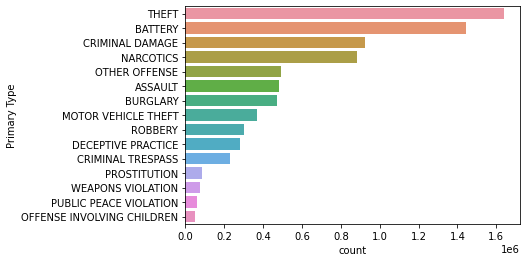

In [15]:
sns.countplot(y = 'Primary Type', data = chicago_df, order=chicago_df['Primary Type'].value_counts().iloc[:15].index)

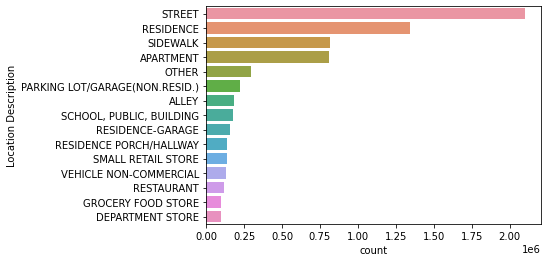

In [16]:
sns.countplot(y = 'Location Description', data= chicago_df, order=chicago_df['Location Description'].value_counts().iloc[:15].index)

In [17]:
## gives me how many rows i have with same 'Y' year index
chicago_df.resample('Y').size()

Date
2001-12-31    568518
2002-12-31    490879
2003-12-31    475913
2004-12-31    388205
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

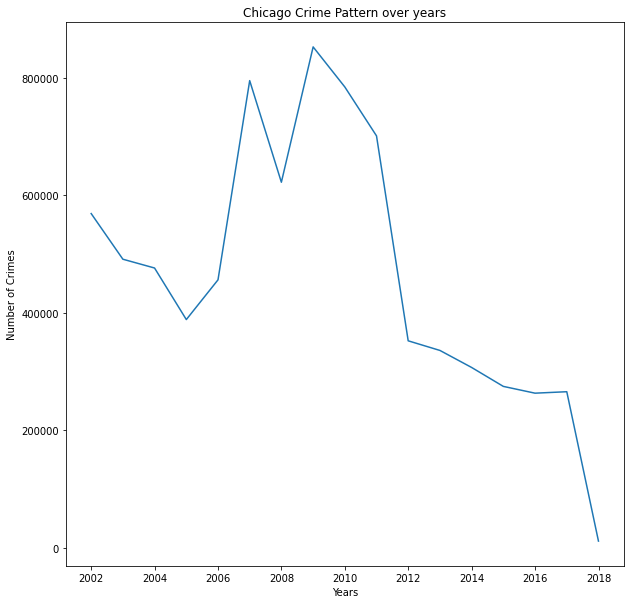

In [18]:
plt.figure(figsize=(10,10))
plt.plot(chicago_df.resample('Y').size())
plt.title('Chicago Crime Pattern over years')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

In [19]:
chicago_df.resample('m').size(
)

Date
2001-01-31    74995
2001-02-28    66288
2001-03-31    53122
2001-04-30    40166
2001-05-31    41876
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 193, dtype: int64

In [22]:
## i tried to give months to the label. However, it was so messed up and everything were overlapped with eacother
#so i commented out


#ticks=chicago_df.resample('m').size(
#).index
#labels=chicago_df.resample('m').size(
#).index
#labels

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31'],
              dtype='datetime64[ns]', name='Date', length=193, freq='M')

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31'],
              dtype='datetime64[ns]', name='Date', length=193, freq='M')

Text(0, 0.5, 'Number of Crimes')

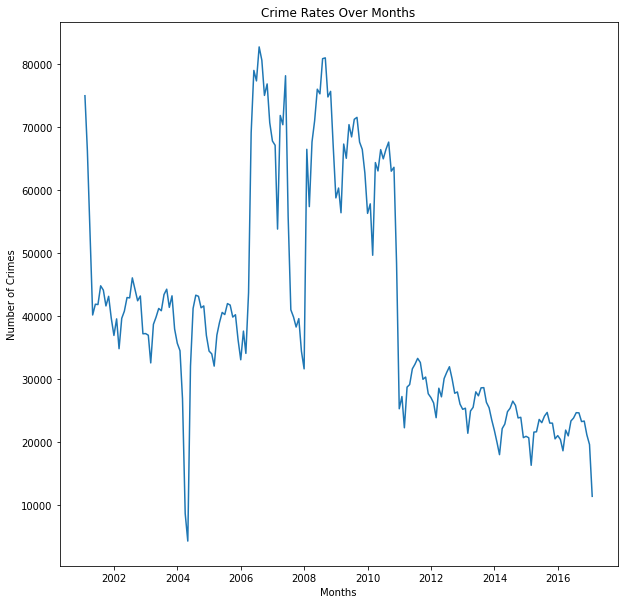

In [35]:
plt.figure(figsize=(10,10))
plt.plot(chicago_df.resample('m').size())
plt.title('Crime Rates Over Months')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

In [36]:
#reset the index 
chicago_prophet = chicago_df.resample('M').size().reset_index()

In [38]:
chicago_prophet

,Date,0
0,2001-01-31,74995
1,2001-02-28,66288
2,2001-03-31,53122
3,2001-04-30,40166
4,2001-05-31,41876
...,...,...
188,2016-09-30,23235
189,2016-10-31,23314
190,2016-11-30,21140
191,2016-12-31,19580


In [41]:
chicago_prophet.columns = ['Date','Crime Count']
chicago_prophet

,Date,Crime Count
0,2001-01-31,74995
1,2001-02-28,66288
2,2001-03-31,53122
3,2001-04-30,40166
4,2001-05-31,41876
...,...,...
188,2016-09-30,23235
189,2016-10-31,23314
190,2016-11-30,21140
191,2016-12-31,19580


In [42]:
chicago_prophet_final =  chicago_prophet.rename(columns={'Date':'ds', 'Crime Count': 'y'})

In [44]:
chicago_prophet_final

,ds,y
0,2001-01-31,74995
1,2001-02-28,66288
2,2001-03-31,53122
3,2001-04-30,40166
4,2001-05-31,41876
...,...,...
188,2016-09-30,23235
189,2016-10-31,23314
190,2016-11-30,21140
191,2016-12-31,19580


In [46]:
model = Prophet()
model.fit(chicago_prophet_final)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
future = model.make_future_dataframe(periods=730)
forecast = model.predict(future)

In [52]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-31,40548.488274,22672.997023,54486.553205,40548.488274,40548.488274,-1578.253465,-1578.253465,-1578.253465,-1578.253465,-1578.253465,-1578.253465,0.0,0.0,0.0,38970.234809
1,2001-02-28,40695.732253,18041.013263,50445.551612,40695.732253,40695.732253,-6453.992631,-6453.992631,-6453.992631,-6453.992631,-6453.992631,-6453.992631,0.0,0.0,0.0,34241.739623
2,2001-03-31,40858.752373,21970.782451,54372.701410,40858.752373,40858.752373,-2068.601484,-2068.601484,-2068.601484,-2068.601484,-2068.601484,-2068.601484,0.0,0.0,0.0,38790.150889
3,2001-04-30,41016.513779,24510.262454,55662.833223,41016.513779,41016.513779,-1472.229751,-1472.229751,-1472.229751,-1472.229751,-1472.229751,-1472.229751,0.0,0.0,0.0,39544.284028
4,2001-05-31,41179.533899,29645.437915,61623.486814,41179.533899,41179.533899,3883.090066,3883.090066,3883.090066,3883.090066,3883.090066,3883.090066,0.0,0.0,0.0,45062.623965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2019-01-27,3967.197362,-15931.659001,16501.622501,3093.386629,4817.410770,-3603.179504,-3603.179504,-3603.179504,-3603.179504,-3603.179504,-3603.179504,0.0,0.0,0.0,364.017858
919,2019-01-28,3953.201127,-14487.136409,17536.892580,3077.605255,4807.791544,-2925.441691,-2925.441691,-2925.441691,-2925.441691,-2925.441691,-2925.441691,0.0,0.0,0.0,1027.759436
920,2019-01-29,3939.204892,-14985.501682,17422.784784,3061.823882,4797.990825,-2357.051332,-2357.051332,-2357.051332,-2357.051332,-2357.051332,-2357.051332,0.0,0.0,0.0,1582.153560
921,2019-01-30,3925.208657,-14131.117247,17553.875008,3046.042509,4787.577017,-1924.171713,-1924.171713,-1924.171713,-1924.171713,-1924.171713,-1924.171713,0.0,0.0,0.0,2001.036944


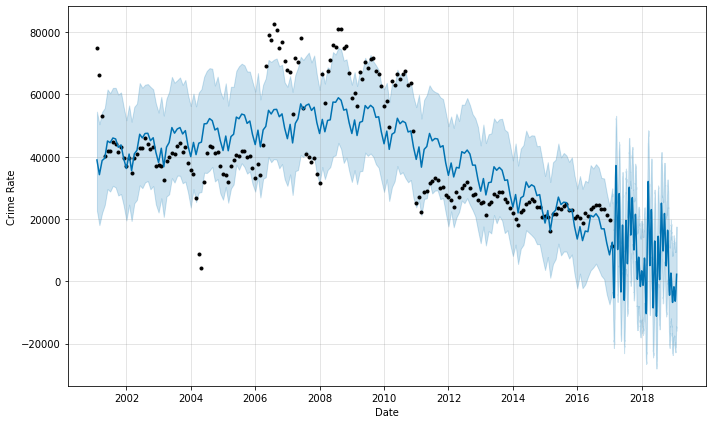

In [53]:
figure = model.plot(forecast, xlabel='Date', ylabel='Crime Rate')

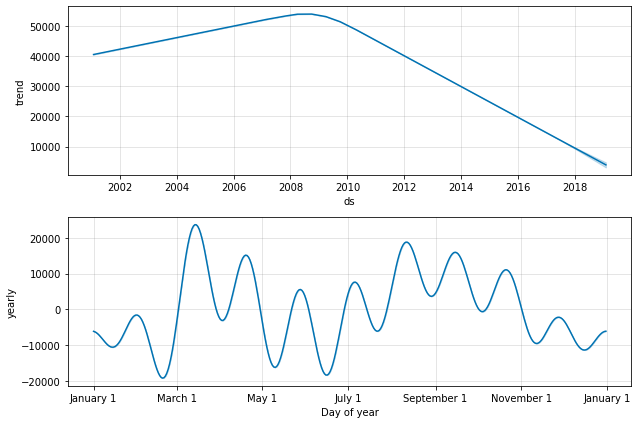

In [54]:
figure = model.plot_components(forecast)